In [1]:
import itertools
from random import random, randrange, choice
import math

In [2]:
class Ant(object):
    def __init__(self, id_, row, column, memory_size, has_trash):
        self.id_ = id_
        self.row = row
        self.column = column
        self.memory_size = memory_size
        self.has_trash = has_trash
        self.memories = [0] * self.memory_size
        
    def update_position(self, new_row, new_column):
        self.column = new_column
        self.row = new_row
        
    def count_memories(self):
        return self.memories.count(1)
    
    def add_memory(self, value):
        self.memories.pop()
        self.memories.insert(0, value)

In [3]:
def check_possible_moves(row, column, ocean, ant_map, vision_range=1):
    left_row = row
    if -1 < row - vision_range < len(ocean.index):
        left_row = row - vision_range
    
    right_row = row
    if -1 < row + vision_range < len(ocean.index):
        right_row = row + vision_range
    
    left_column = column
    if -1 < column - vision_range < len(ocean.columns):
        left_column = column - vision_range
        
    right_column = column
    if -1 < column + vision_range < len(ocean.columns):
        right_column = column + vision_range
    
    ant_vision = ant_map.loc[left_row:right_row, left_column:right_column]

    moves_row = ant_vision.index.tolist()
    moves_column = ant_vision.columns.tolist()
    
    possible_moves = [[r,c] for r in moves_row for c in moves_column if ant_map.at[r, c] == 0 and [r, c] != [row, column]]
    
    return possible_moves

In [4]:
"""def drop_probability(ant, drop_constant):
    fx = ant.count_memories() / ant.memory_size
    return (fx / drop_constant + fx)**2""";

In [5]:
"""def pick_probability(ant, pick_constant):
    fx = ant.count_memories() / ant.memory_size
    return (pick_constant / pick_constant + fx)**2""";

In [6]:
def calculate_euclidean_distance(from_point, to_point):
    a = to_point[0] - from_point[0]
    b = to_point[1] - from_point[1]

    return math.sqrt((a**2) + (b**2))

In [7]:
def calculate_f(row, column, alpha, ocean, ant_map):
    s = 0
    summation = 0
    
    possible_moves = check_possible_moves(row=row,
                                          column=column,
                                          ocean=ocean,
                                          ant_map=ant_map,
                                          vision_range=1)
    
    for move in possible_moves:
        s += 1
        if ocean.at[move[0], move[1]] == 1:
            distance = calculate_euclidean_distance(from_point=[move[0], move[1]],
                                                    to_point=[row, column])
            summation += (1 - distance/alpha)

    try:
        fi = summation/s
        if fi < 0:
            fi = 0
    except ZeroDivisionError:
        fi = 0
    
    return fi

In [8]:
def move_ants(ocean, ants, ant_map, drop_constant, pick_constant, alpha):
    random_value = random()
    
    for ant in ants:
        possible_moves = check_possible_moves(row=ant.row,
                                              column=ant.column,
                                              ocean=ocean,
                                              ant_map=ant_map,
                                              vision_range=1)
        
        if len(possible_moves) > 0:
            ant_map.at[ant.row, ant.column] = 0
            
            move = choice(possible_moves)

            ant_map.at[move[0], move[1]] = 1
            ant.row = move[0]
            ant.column = move[1]
            
            if ocean.at[move[0], move[1]] == 1 and ant.has_trash == 0:
                fi = calculate_f(row=move[0],
                                 column=move[1],
                                 alpha=alpha,
                                 ocean=ocean,
                                 ant_map=ant_map)
                
                pick_value = (pick_constant / (pick_constant + fi))**2
                
                if random_value < pick_value:
                    ocean.at[move[0], move[1]] = 0
                    ant.has_trash = 1
                
                ant.add_memory(1)
            elif ocean.at[move[0], move[1]] == 1 and ant.has_trash == 1:
                ant.add_memory(1)
            elif ocean.at[move[0], move[1]] == 0 and ant.has_trash == 1:
                fi = calculate_f(row=move[0],
                                 column=move[1],
                                 alpha=alpha,
                                 ocean=ocean,
                                 ant_map=ant_map)
                
                drop_value = 2 * fi if fi < drop_constant else 1
                
                if random_value < drop_value:
                    ocean.at[move[0], move[1]] = 1
                    ant.has_trash = 0
                
                ant.add_memory(0)
            elif ocean.at[move[0], move[1]] == 0 and ant.has_trash == 0:
                ant.add_memory(0)

**DISEÑAR ALGORITMO CON UNA HORMIGA PARA VER SU COMPORTAMIENTO Y EFICIENCIA**

Una hormiga comprobará todas las posiciones visitables del mapa, y si dichas posiciones están o no en su memoria, que en caso de estarlo y no ser un punto de recogida no se visitarán. Pero si por el contrario, la hormiga tiene basura y ha depositado basura en una posición aún en su memoria, retrocederá hasta dicha concentración de basura para soltarla, sino buscará una posible ubicación aleatoria. Sino, por defecto, la hormiga sigue un recorrido aleatorio tenga o no basura y/o información del destino.

In [9]:
import pickle

In [10]:
with open('test_data.pickle', 'rb') as data:
    ocean = pickle.load(data)

In [11]:
total_trash = 0

for _, row in ocean.iterrows():
    for value in row:
        if value == 1:
            total_trash += 1
            
print(f"BASURA INICIAL => {total_trash}")

BASURA INICIAL => 967


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(ocean, cmap=['#b1dff6', '#804000'], vmin=0, vmax=1)
plt.close()

In [14]:
import pandas as pd

In [15]:
data = [[0 for _ in range(len(ocean.columns))] for _ in range(len(ocean.index))]
ant_map = pd.DataFrame(data)

In [16]:
ants = list()

total_ants = 300
memory_size = 10

In [17]:
for ant in range(1, total_ants + 1):
    flag = False
    
    while flag is False:
        row = randrange(len(ocean.index))
        column = randrange(len(ocean.columns))

        if ant_map.at[row, column] == 1:
            pass

        ants.append(Ant(id_=ant,
                        row=row,
                        column=column,
                        memory_size=memory_size,
                        has_trash=0))

        ant_map.at[row, column] = 1
        flag = True

In [18]:
%%time

total_steps = steps = 50000
drop_constant = .35
pick_constant = .1
alpha = 2.1

while steps > 0:
    move_ants(ocean=ocean,
              ants=ants,
              ant_map=ant_map,
              drop_constant=drop_constant,
              pick_constant=pick_constant,
              alpha=alpha)
    
    if steps % 1000 == 0:
        print(f"Step Nº{steps}")
        fig = plt.figure(figsize=(20,15))
        ax = sns.heatmap(ocean, annot=False, cmap=['#b1dff6', '#804000'], vmin=0, vmax=1, cbar=False)
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.get_legend()
        plt.savefig('images/step_' + str(total_steps - steps) + '.png', transparent=True)
        plt.close()
    
    steps -= 1

fig = plt.figure(figsize=(20,15))
ax = sns.heatmap(ocean, annot=False, cmap=['#b1dff6', '#804000'], vmin=0, vmax=1, cbar=False)
ax.set_axis_off()
fig.add_axes(ax)
ax.get_legend()
plt.savefig('images/step_' + str(total_steps - steps) + '.png', transparent=True)
plt.close()

Step Nº50000
Step Nº49000
Step Nº48000
Step Nº47000
Step Nº46000
Step Nº45000
Step Nº44000
Step Nº43000
Step Nº42000
Step Nº41000
Step Nº40000
Step Nº39000
Step Nº38000
Step Nº37000
Step Nº36000
Step Nº35000
Step Nº34000
Step Nº33000
Step Nº32000
Step Nº31000
Step Nº30000
Step Nº29000
Step Nº28000
Step Nº27000
Step Nº26000
Step Nº25000
Step Nº24000
Step Nº23000
Step Nº22000
Step Nº21000
Step Nº20000
Step Nº19000
Step Nº18000
Step Nº17000
Step Nº16000
Step Nº15000
Step Nº14000
Step Nº13000
Step Nº12000
Step Nº11000
Step Nº10000
Step Nº9000
Step Nº8000
Step Nº7000
Step Nº6000
Step Nº5000
Step Nº4000
Step Nº3000
Step Nº2000
Step Nº1000
CPU times: user 1h 19min 3s, sys: 1min 26s, total: 1h 20min 29s
Wall time: 3h 8min 9s


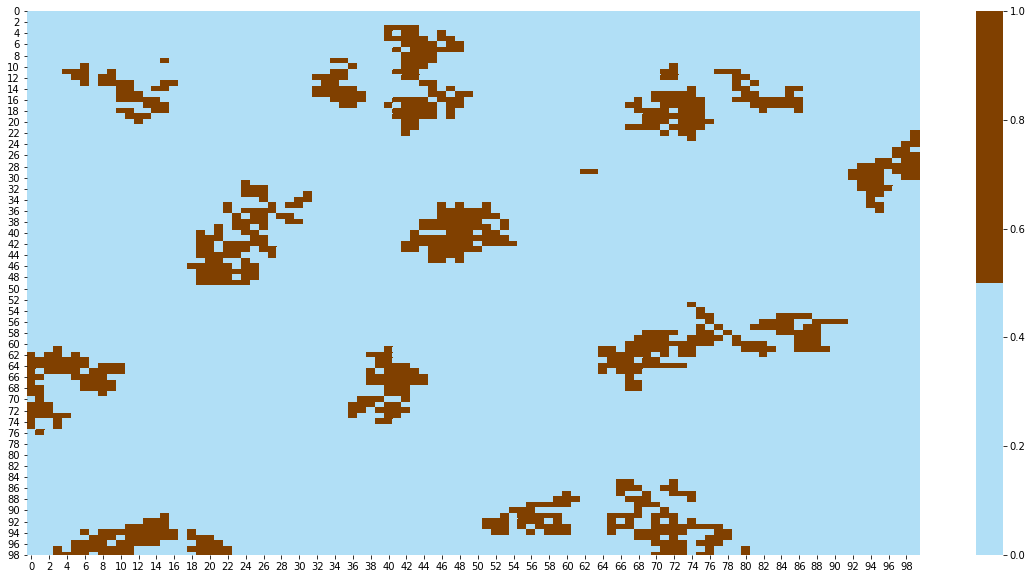

In [19]:
plt.figure(figsize=(20,10))
sns.heatmap(ocean, cmap=['#b1dff6', '#804000'], vmin=0, vmax=1)

In [20]:
trash_count = 0

for _, row in ocean.iterrows():
    for value in row:
        if value == 1:
            trash_count += 1
            
print(f"BASURA FINAL => {trash_count}")

BASURA FINAL => 900


In [21]:
for ant in ants:
    if ant.has_trash == 1:
        print(f"HORMIGA {ant.id_} CON BASURA!")

HORMIGA 2 CON BASURA!
HORMIGA 8 CON BASURA!
HORMIGA 10 CON BASURA!
HORMIGA 11 CON BASURA!
HORMIGA 12 CON BASURA!
HORMIGA 24 CON BASURA!
HORMIGA 25 CON BASURA!
HORMIGA 29 CON BASURA!
HORMIGA 31 CON BASURA!
HORMIGA 33 CON BASURA!
HORMIGA 38 CON BASURA!
HORMIGA 44 CON BASURA!
HORMIGA 46 CON BASURA!
HORMIGA 61 CON BASURA!
HORMIGA 67 CON BASURA!
HORMIGA 68 CON BASURA!
HORMIGA 73 CON BASURA!
HORMIGA 78 CON BASURA!
HORMIGA 80 CON BASURA!
HORMIGA 81 CON BASURA!
HORMIGA 82 CON BASURA!
HORMIGA 83 CON BASURA!
HORMIGA 92 CON BASURA!
HORMIGA 101 CON BASURA!
HORMIGA 106 CON BASURA!
HORMIGA 109 CON BASURA!
HORMIGA 119 CON BASURA!
HORMIGA 123 CON BASURA!
HORMIGA 124 CON BASURA!
HORMIGA 131 CON BASURA!
HORMIGA 141 CON BASURA!
HORMIGA 150 CON BASURA!
HORMIGA 156 CON BASURA!
HORMIGA 162 CON BASURA!
HORMIGA 164 CON BASURA!
HORMIGA 166 CON BASURA!
HORMIGA 168 CON BASURA!
HORMIGA 169 CON BASURA!
HORMIGA 171 CON BASURA!
HORMIGA 177 CON BASURA!
HORMIGA 180 CON BASURA!
HORMIGA 181 CON BASURA!
HORMIGA 185 CON B

In [22]:
ants_with_trash = 0

for ant in ants:
    if ant.has_trash == 1:
        ants_with_trash += 1
        
print(f"HORMIGAS CON BASURA AL FINAL => {ants_with_trash}")

HORMIGAS CON BASURA AL FINAL => 67
